In [67]:
import pandas as pd

all_train = pd.read_csv('./data/titanic/train.csv')  

In [68]:
#manual train test split
#to make sure the distribution of label "survived" are the same on train and test
from sklearn.model_selection import train_test_split

train, test = train_test_split(all_train, test_size=0.25 , random_state=1337,stratify = all_train['Survived'])


In [69]:
test_id = test['PassengerId']
del train['PassengerId']
del test['PassengerId']

# preprocessing

Missing Value

In [70]:
#categorical
train[['Cabin', 'Embarked']] = train[['Cabin','Embarked']].fillna(value='Missing')
test[['Cabin', 'Embarked']] = test[['Cabin','Embarked']].fillna(value='Missing')

C:\Users\willy\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [71]:
#numerical, using train data's mean value
test['Age'] = test['Age'].fillna(value=train['Age'].mean())
test['Fare'] = test['Fare'].fillna(value=train['Fare'].mean()) 
train['Age'] = train['Age'].fillna(value=train['Age'].mean())

C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Identify categorical columns

In [72]:
train.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [73]:
# Catboost need to know which columns are categorical, I simply change the categorical columns datatype to object

In [74]:
def change_column_dtype_to_object(name):
    train[name] = train[name].astype('object')
    test[name] = test[name].astype('object')

In [75]:
change_column_dtype_to_object("Name")
change_column_dtype_to_object("Sex")
change_column_dtype_to_object("Ticket")
change_column_dtype_to_object("Cabin")
change_column_dtype_to_object("Embarked")

C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Categorical column encoding

In [76]:
import numpy as np

In [77]:
cat_col_list = train.dtypes[train.dtypes == object].index.tolist()

# Unseen test categorical column values
solution: https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

In [78]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [79]:
#record the original value 
cat_col_ref_dict  = {}

from sklearn.preprocessing import LabelEncoder
le = LabelEncoderExt()
for i in cat_col_list:
    le.fit(train[i])
    train[i] = le.transform(train[i])
    test[i] = le.transform(test[i])
    cat_col_ref_dict.update({i : le.classes_})

C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [80]:
#making sure those cateogrical variables are dtype "category"
#and use label encoding
for col in cat_col_list:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [81]:
train # Names are all unseen, its like ID, should I delete?

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
437,1,2,524,1,24.000000,2,3,187,18.7500,119,3
418,0,2,393,2,30.000000,0,0,178,13.0000,119,3
671,0,1,153,2,31.000000,1,0,452,52.0000,31,3
756,0,3,108,2,28.000000,0,0,324,7.7958,119,3
613,0,3,289,2,29.645526,0,0,377,7.7500,119,2
...,...,...,...,...,...,...,...,...,...,...,...
429,1,3,506,2,32.000000,0,0,515,8.0500,94,3
372,0,3,57,2,19.000000,0,0,216,8.0500,119,3
393,1,1,446,1,23.000000,1,0,334,113.2750,83,0
743,0,3,405,2,24.000000,1,0,384,16.1000,119,3


# Modeling using partial of training data

In [82]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500) 

In [83]:
X = train.drop(['Survived'], axis=1)
y = train[['Survived']]

In [84]:
from sklearn.model_selection import train_test_split

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, train_size=0.75, random_state=1337,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, train_size=0.75, random_state=1337,stratify=y_train_and_val)

In [85]:
import numpy as np
import lightgbm as lgb

In [86]:
lgb_train = lgb.Dataset(X_train, y_train,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                        free_raw_data=False)

In [87]:
num_train, num_feature = X_train.shape

In [88]:
# generate feature names
# feature_name = ['feature_' + str(col) for col in range(num_feature)]
feature_name = X_train.columns.tolist()

In [89]:
categorical_features_indices = np.where(X.dtypes == "category")[0]

In [90]:
categorical_features_indices

array([1, 2, 6, 8, 9], dtype=int64)

In [91]:
# specify your configurations as a dict
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'early_stopping_rounds' : 100,
    'verbose': 0
}

In [92]:
evals_result = {}  # to record eval results for plotting

In [93]:
print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                feature_name=feature_name,
                categorical_feature=categorical_features_indices.tolist(),
                evals_result=evals_result
               )

Starting training...
[1]	valid_0's binary_logloss: 0.624518
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.592848
[3]	valid_0's binary_logloss: 0.567897
[4]	valid_0's binary_logloss: 0.548117
[5]	valid_0's binary_logloss: 0.532596
[6]	valid_0's binary_logloss: 0.520076
[7]	valid_0's binary_logloss: 0.510268
[8]	valid_0's binary_logloss: 0.50014
[9]	valid_0's binary_logloss: 0.492709
[10]	valid_0's binary_logloss: 0.48539
[11]	valid_0's binary_logloss: 0.479668
[12]	valid_0's binary_logloss: 0.474439
[13]	valid_0's binary_logloss: 0.47066
[14]	valid_0's binary_logloss: 0.467404
[15]	valid_0's binary_logloss: 0.4643
[16]	valid_0's binary_logloss: 0.462606
[17]	valid_0's binary_logloss: 0.460637
[18]	valid_0's binary_logloss: 0.459384
[19]	valid_0's binary_logloss: 0.456386
[20]	valid_0's binary_logloss: 0.454546
[21]	valid_0's binary_logloss: 0.450517
[22]	valid_0's binary_logloss: 0.447581
[23]	valid_0's binary_logloss: 0.447794
[24]	valid_

C:\Users\willy\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\willy\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 2, 6, 8, 9]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[81]	valid_0's binary_logloss: 0.502748
[82]	valid_0's binary_logloss: 0.504898
[83]	valid_0's binary_logloss: 0.507618
[84]	valid_0's binary_logloss: 0.509009
[85]	valid_0's binary_logloss: 0.510677
[86]	valid_0's binary_logloss: 0.51119
[87]	valid_0's binary_logloss: 0.511494
[88]	valid_0's binary_logloss: 0.512594
[89]	valid_0's binary_logloss: 0.516072
[90]	valid_0's binary_logloss: 0.517188
[91]	valid_0's binary_logloss: 0.51686
[92]	valid_0's binary_logloss: 0.518068
[93]	valid_0's binary_logloss: 0.52077
[94]	valid_0's binary_logloss: 0.521174
[95]	valid_0's binary_logloss: 0.522092
[96]	valid_0's binary_logloss: 0.522234
[97]	valid_0's binary_logloss: 0.523028
[98]	valid_0's binary_logloss: 0.524901
[99]	valid_0's binary_logloss: 0.524762
[100]	valid_0's binary_logloss: 0.525458
[101]	valid_0's binary_logloss: 0.527203
[102]	valid_0's binary_logloss: 0.529463
[103]	valid_0's binary_logloss: 0.530794
[104]	valid_0's binary_logloss: 0.531631
[105]	valid_0's binary_logloss: 0.5338

In [94]:
# feature names
print('Feature names:', gbm.feature_name())

# feature importances
print('Feature importances:', list(gbm.feature_importance()))

Feature names: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Feature importances: [27, 0, 24, 140, 9, 4, 0, 77, 16, 24]


feature importance plot

In [95]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

Plotting metrics recorded during training...


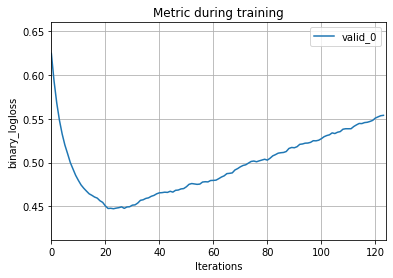

In [96]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


Plotting feature importances...


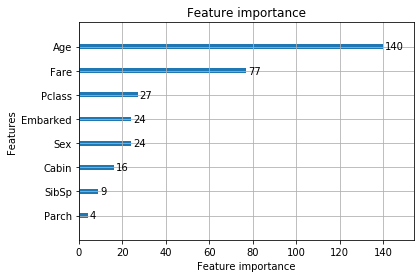

In [97]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

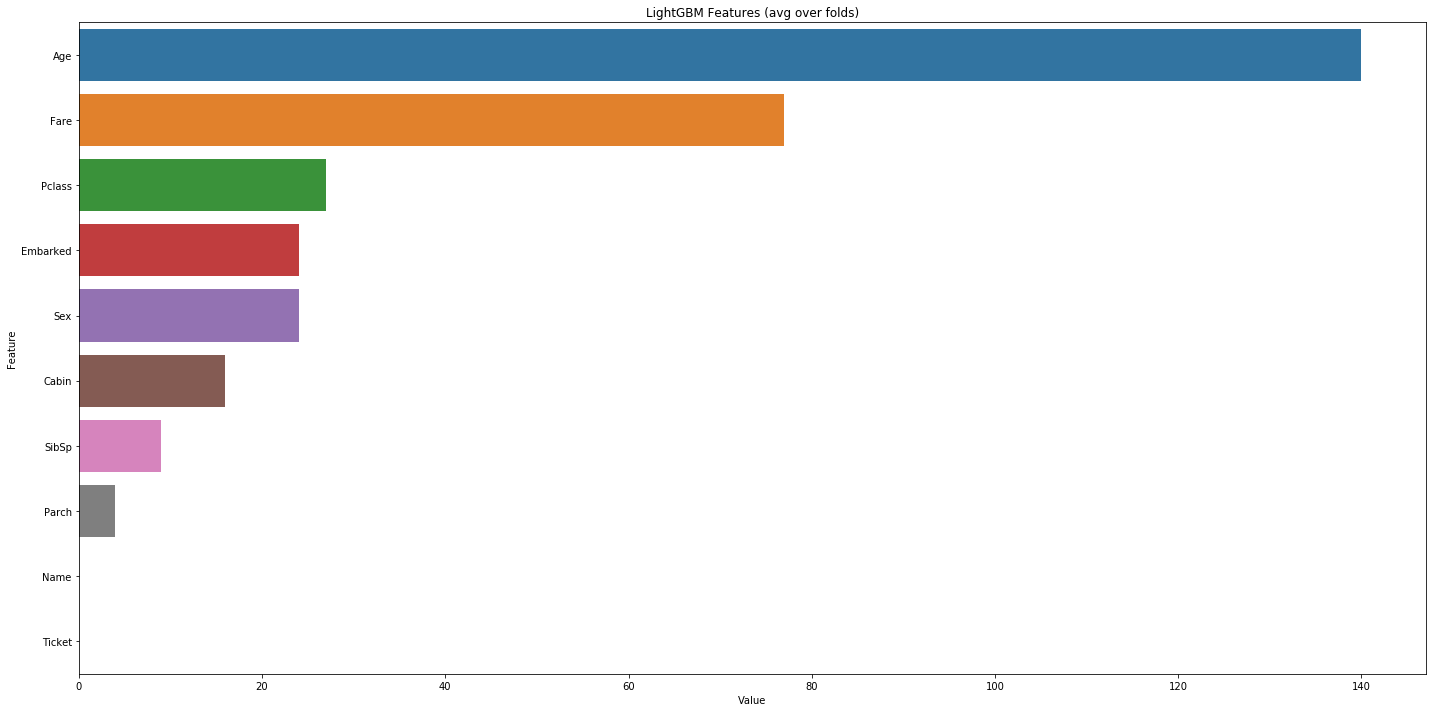

In [98]:
# more beautiful plot code

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

# AUC score using small part of training data for evaluation

In [99]:
predictions_probs = gbm.predict(X_test)
# keep probabilities for the positive outcome only
pos_probs = predictions_probs

In [100]:
threshold = 0.4 # threshold we set where the probability prediction must be above this to be classified as a '1'
classes = predictions_probs.copy() # say it is the class in the second column you care about predictint
classes[classes>=threshold] = 1
classes[classes<threshold] = 0

In [101]:
uniqueValues, occurCount = np.unique(classes, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0. 1.]
Occurrence Count :  [108  59]


In [102]:
from sklearn import metrics

In [103]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_probs, pos_label=1)

In [104]:
roc_auc = metrics.auc(fpr, tpr)

In [105]:
lgb_auc = metrics.roc_auc_score(y_test, pos_probs)

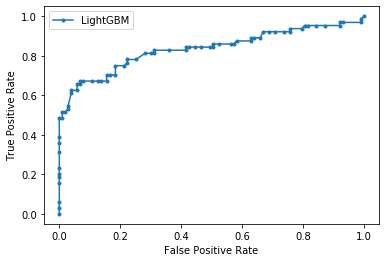

In [106]:
from matplotlib import pyplot
lgb_fpr, lgb_tpr, _ = metrics.roc_curve(y_test, pos_probs)
# plot the roc curve for the model
pyplot.plot(lgb_fpr, lgb_tpr, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [107]:
lgb_auc

0.8357858009708738

# Modeling using all training data to predict test data

In [108]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500) 

In [109]:
X = train.drop(['Survived'], axis=1)
y = train[['Survived']]

In [110]:
from sklearn.model_selection import train_test_split

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X, y, train_size=0.75, random_state=1337,stratify=y)


In [111]:
lgb_train = lgb.Dataset(X_train_sub, y_train_sub,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_val_sub, y_val_sub, reference=lgb_train,
                        free_raw_data=False)

In [112]:
num_train, num_feature = X_train_sub.shape

In [113]:
# generate feature names
# feature_name = ['feature_' + str(col) for col in range(num_feature)]
feature_name = X_train_sub.columns.tolist()

In [114]:
categorical_features_indices = np.where(X.dtypes == "category")[0]

In [115]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'early_stopping_rounds' : 100,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [116]:
evals_result = {}  # to record eval results for plotting

In [117]:
%%time
print('Starting training...')
# feature_name and categorical_feature
final_model = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                feature_name=feature_name,
                categorical_feature=categorical_features_indices.tolist(),
                evals_result=evals_result
               )

Starting training...
[1]	valid_0's binary_logloss: 0.656366
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.634991
[3]	valid_0's binary_logloss: 0.627974
[4]	valid_0's binary_logloss: 0.621207
[5]	valid_0's binary_logloss: 0.603539
[6]	valid_0's binary_logloss: 0.586319
[7]	valid_0's binary_logloss: 0.571878
[8]	valid_0's binary_logloss: 0.55829
[9]	valid_0's binary_logloss: 0.554197
[10]	valid_0's binary_logloss: 0.542461
[11]	valid_0's binary_logloss: 0.531988
[12]	valid_0's binary_logloss: 0.52245
[13]	valid_0's binary_logloss: 0.51321
[14]	valid_0's binary_logloss: 0.504413
[15]	valid_0's binary_logloss: 0.501896
[16]	valid_0's binary_logloss: 0.495227
[17]	valid_0's binary_logloss: 0.489015
[18]	valid_0's binary_logloss: 0.483537
[19]	valid_0's binary_logloss: 0.478417
[20]	valid_0's binary_logloss: 0.47434
[21]	valid_0's binary_logloss: 0.468398
[22]	valid_0's binary_logloss: 0.462952
[23]	valid_0's binary_logloss: 0.458076
[24]	valid

C:\Users\willy\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\willy\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 2, 6, 8, 9]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[70]	valid_0's binary_logloss: 0.416893
[71]	valid_0's binary_logloss: 0.416565
[72]	valid_0's binary_logloss: 0.416254
[73]	valid_0's binary_logloss: 0.414791
[74]	valid_0's binary_logloss: 0.412844
[75]	valid_0's binary_logloss: 0.411743
[76]	valid_0's binary_logloss: 0.412103
[77]	valid_0's binary_logloss: 0.411086
[78]	valid_0's binary_logloss: 0.410232
[79]	valid_0's binary_logloss: 0.41014
[80]	valid_0's binary_logloss: 0.409852
[81]	valid_0's binary_logloss: 0.408979
[82]	valid_0's binary_logloss: 0.40802
[83]	valid_0's binary_logloss: 0.408136
[84]	valid_0's binary_logloss: 0.408347
[85]	valid_0's binary_logloss: 0.408002
[86]	valid_0's binary_logloss: 0.408436
[87]	valid_0's binary_logloss: 0.407872
[88]	valid_0's binary_logloss: 0.408728
[89]	valid_0's binary_logloss: 0.408526
[90]	valid_0's binary_logloss: 0.409117
[91]	valid_0's binary_logloss: 0.409446
[92]	valid_0's binary_logloss: 0.409914
[93]	valid_0's binary_logloss: 0.408808
[94]	valid_0's binary_logloss: 0.40832
[9

In [118]:
# feature names
print('Feature names:', final_model.feature_name())

# feature importances
print('Feature importances:', list(final_model.feature_importance()))

Feature names: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Feature importances: [91, 0, 84, 476, 52, 39, 0, 481, 51, 78]


feature importance plot

In [119]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

Plotting metrics recorded during training...


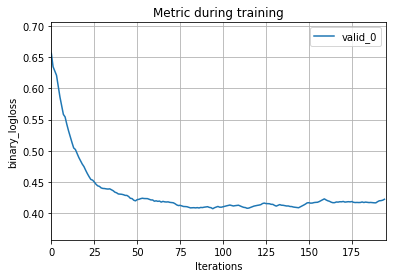

In [120]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


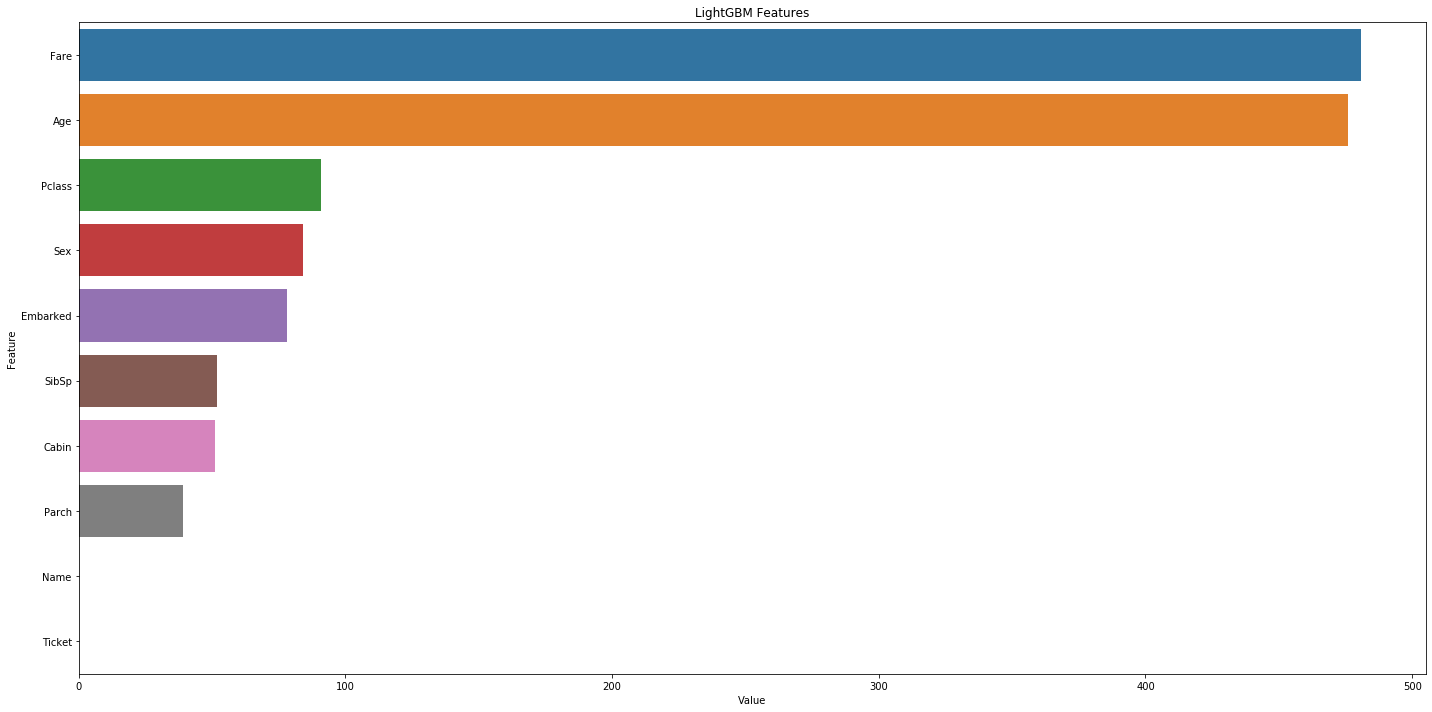

In [134]:
# more beautiful plot code

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(final_model.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

# Test dataset AUC score

In [122]:
X_test = test.drop(['Survived'], axis=1)
y_test = test['Survived']

In [123]:
predictions_probs = final_model.predict(X_test)
# keep probabilities for the positive outcome only
pos_probs = predictions_probs

In [124]:
import statistics
median_predict_value = statistics.median(pos_probs)

In [125]:
train['Survived'].value_counts()

0    412
1    256
Name: Survived, dtype: int64

In [126]:
positive_ratio = 256/(412+256)

In [127]:
threshold = positive_ratio # threshold we set where the probability prediction must be above this to be classified as a '1'
classes = predictions_probs.copy() # say it is the class in the second column you care about predictint
classes[classes>=threshold] = 1
classes[classes<threshold] = 0

In [128]:
uniqueValues, occurCount = np.unique(classes, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0. 1.]
Occurrence Count :  [134  89]


In [129]:
from sklearn import metrics

In [130]:
lgb_auc = metrics.roc_auc_score(y_test, pos_probs)

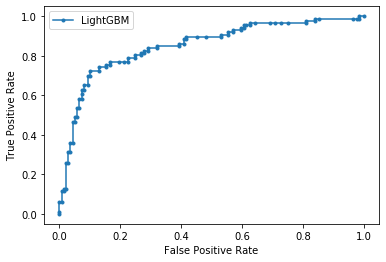

In [131]:
from matplotlib import pyplot
lgb_fpr, lgb_tpr, _ = metrics.roc_curve(y_test, pos_probs)
# plot the roc curve for the model
pyplot.plot(lgb_fpr, lgb_tpr, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [132]:
lgb_auc

0.8510439653709047

# Submission file

In [ ]:
# kaggle uses accuracy for this competition, but we want to use AUC

In [114]:
# resultdf = pd.DataFrame(columns=['PassengerId', 'Survived'])

In [115]:
# resultdf['Id'] = test_id
# resultdf['y'] = classes

In [116]:
# resultdf.to_csv('./output/titanic/submission(lgbm,threshold = positive_ratio).csv',index=False)

In [ ]:
# submit on https://www.kaggle.com/c/bank-marketing-uci/leaderboard#score